# Laboration - 
## <i>Kurs i Statistika Metoder </i>
#### av Pontus Johansson



## Introduktion
I denna laboration är byggd utifrån min tolkning utav [labrations PM](Laboration_Statistiska_Metoder.pdf). Där jag har byggt [linear_regression.py](linear_regression.py) för att bygga mina modeller. Här kommer en kort sammanfattning: 
 Detta projekt tillämpas Multipel Linjär Regression för att modellera sambandet mellan huspriser och oberoende variabler. Modellen är byggd från grunden och baseras på följande matematiska principer:
 Minsta Kvadratmetoden (OLS): Koefficienterna ($\beta$) skattas analytiskt genom Normalekvationen:$$\hat{\beta} = (X^T X)^{-1} X^T y$$Modellutvärdering:$R^2$ (Determinationskoefficient): Mäter hur stor andel av variansen i priset som modellen förklarar.
 RMSE (Root Mean Squared Error): Mäter det genomsnittliga felet i dollar.
 
 Signifikanstester (Hypotesprövning):
 F-test: Avgör om modellen som helhet är statistiskt signifikant jämfört med enbart medelvärdet.
 
 T-test & P-värden: Testar varje enskild variabels signifikans. Ett P-värde $< 0.05$ indikerar att variabeln har en säkerställd påverkan på priset.
 
 Osäkerhetsanalys:Konfidensintervall: Beräknar intervallet (t.ex. 95%) inom vilket det sanna värdet för varje koefficient sannolikt ligger.Pearsons Korrelation: Används för att identifiera linjära samband mellan variabler och upptäcka multikollinearitet.

Jag började med att göra en utforskning av datan i [data_exploration.ipynb](data_exploration.ipynb), där jag gjorde den grundläggande data behandlingen och utforskningen innan jag började med detta slut dokument.Se gärna in den notebooken ifall du vill veta mer om hur jag kom fram till mina beslut.

Nu tänkte jag att vi skulle snabbt behandla datan och sedan använda min class `LinearRegression`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from linear_regression import LinearRegression

path = "data/"
df = pd.read_csv(path + "housing.csv")
model = LinearRegression()

Det första jag gjorde i min data behandling var att utforska datan och se ifall det fanns några NaN värden. Jag såg att `total_bedrooms` saknade 207 värden och var ca 1 % av datasetet. Då den inte överskred 5 % så valde jag att ersätta dessa värden medhjälp av att ta `median_ratio` från `ratio` från totala sovrum delat på totalarum så att jag kunde ha ett mellan snitt på hur många sovrum det fanns per totala rum i genomsnitt på hela datasetet. Jag valde att ta genomsnittet på detta sättet istället för att ta median över alla sovrum. Då det skulle ge en felaktiga värden. T.ex. så kan inte en fastighet ha 154 rum och 465 sovrum? Det hade blivit helt fel. Så låt oss ändra detta!

In [2]:
df_no_na = df.dropna(subset=["total_bedrooms"])
ratio = df_no_na["total_bedrooms"] / df_no_na["total_rooms"]
median_ratio = ratio.median()
df["total_bedrooms"] = df["total_bedrooms"].fillna(median_ratio * df["total_rooms"])

Efter att jag ersatte den saknade datan, så hittade jag i min utforskning att det var ganska många höga värden i columnen `median_house_value`. Det fanns 965 värden på 500001 $ och detta kan bero på att median värdet är högre för att det finns ännu högre uträkningar som spelar roll. När jag titta på hur mycket av denna data som påverkar datasetet var det mindre än 5 procent och jag tog beslutet att ta bort den helt. För att ge ett mer balanserat slutresultat. 

In [3]:
df = df[df["median_house_value"] < 500001]

Det jag valde att göra sedan är att förbereda den kategoriska datan så att att jag kan göra en numerisk data behandling. Jag använde mig utav den färdiga funktionen `.get_dummies`.

In [4]:
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True, dtype=int)

Jag ville också förberedda datasetet lite mer, insåg jag att correlationen mellan totala rum, totala sovrum, hushåll och population hade en stark correlation och för att underlätta uträkningarna valde jag att skapa egna columner för att mer få ett snitt. Då de kan skilja sig väldigt mellan hur mycket personer, hushåll, rum och sovrum det finns på olika platser. Genom att ta ett snitt blir det inte lika spritt.

In [5]:
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_household"] = df["population"] / df["households"]

Nu när datasetet är redo för att omvandlas till X, y och att börja använda vår modell. För att Göra detta behöver jag förbereda datasetet.

In [6]:
cols_to_drop = [
    'median_house_value', 
    'total_rooms', 
    'total_bedrooms', 
    'population', 
    'households'
]

X = df.drop(columns=cols_to_drop)
y = df['median_house_value'].values
feature_names = X.columns.tolist()

X.shape, y.shape

((19675, 11), (19675,))

### Låt oss använda LinearRegression

In [14]:
model.fit(X, y)

Innan vi summerar modellen tänkte jag skriva ut d, n, sample variance och standard deviation. För att se att de fungerar.

In [18]:
print("--- Modellens Egenskaper ---")
print(f"Antal features (d): {model.d}")
print(f"Antal observationer (n): {model.n}")

print("\n--- Statistik & Felanalys ---")
print(f"Sample Variance (y): {model.variance_y():.4f}")
print(f"Standard Deviation (y): {model.standard_deviation_y():.4f}")

print(f"RMSE (Modellfel): {model.RMSE():.4f}")

--- Modellens Egenskaper ---
Antal features (d): 11
Antal observationer (n): 19675

--- Statistik & Felanalys ---
Sample Variance (y): 187838284468805.2812
Standard Deviation (y): 97711.5096
RMSE (Modellfel): 62445.5606


Datamängden bestod av 19 675 observationer och 11 features. Den naturliga spridningen i huspriser (Standardavvikelse) var $97 711. Genom att tillämpa den linjära regressionsmodell lyckades den sänka osäkerheten (RMSE) till $62 445. Detta indikerar att modellen lyckas förklara en betydande del av variationen i priserna.

In [13]:
print("\n-------------------------------- Model Summary --------------------------------")
model.summary(feature_names)


-------------------------------- Model Summary --------------------------------
Feature                        Coeff    P-Value  Statistical Significance
--------------------------------------------------------------------------------
Intercept                 -2163627.2980     0.0000                         *
longitude                 -24068.2855     0.0000                         *
latitude                  -21469.0627     0.0000                         *
housing_median_age          744.7362     0.0000                         *
median_income             42160.6521     0.0000                         *
ocean_proximity_INLAND    -34559.0971     0.0000                         *
ocean_proximity_ISLAND    167512.3218     0.0000                         *
ocean_proximity_NEAR BAY    243.2497     0.8912                          
ocean_proximity_NEAR OCEAN  9091.0828     0.0000                         *
rooms_per_household        2397.4490     0.0000                         *
bedrooms_per_roo

Vad skall man då säga om denna informationen. Det jag tar mest med mig är att: 

Inkomst styr: En stark faktorn är `median_income`. För varje person med högre inkomsten i området, ökar huspriserna med $42 160. Kort sagt kan med säga att rika områden har dyra hus, helt enkelt.

Det är dyrare vid kusten: Läget är avgörande. Att bo i `INLAND` ger en sänktning på priset med $34 559, jämfört med kusten. Att bo på en ö `ISLAND` är extremt exklusivt och höjer priset med $16 7512.

Variabeln `NEAR BAY` är inte statistiskt signifikant (P-värde 0.89). Det betyder att det inte verkar finnas någon prisskillnad mellan att bo nära en bukt och 1 timme från havet som är jämförelsevariabeln.

Modellens säkerhet: Nästan alla variabler har ett P-värde på 0.0000. Det innebär att sambanden vi ser inte är slumpmässiga, modellen är väldigt säker på sin sak.

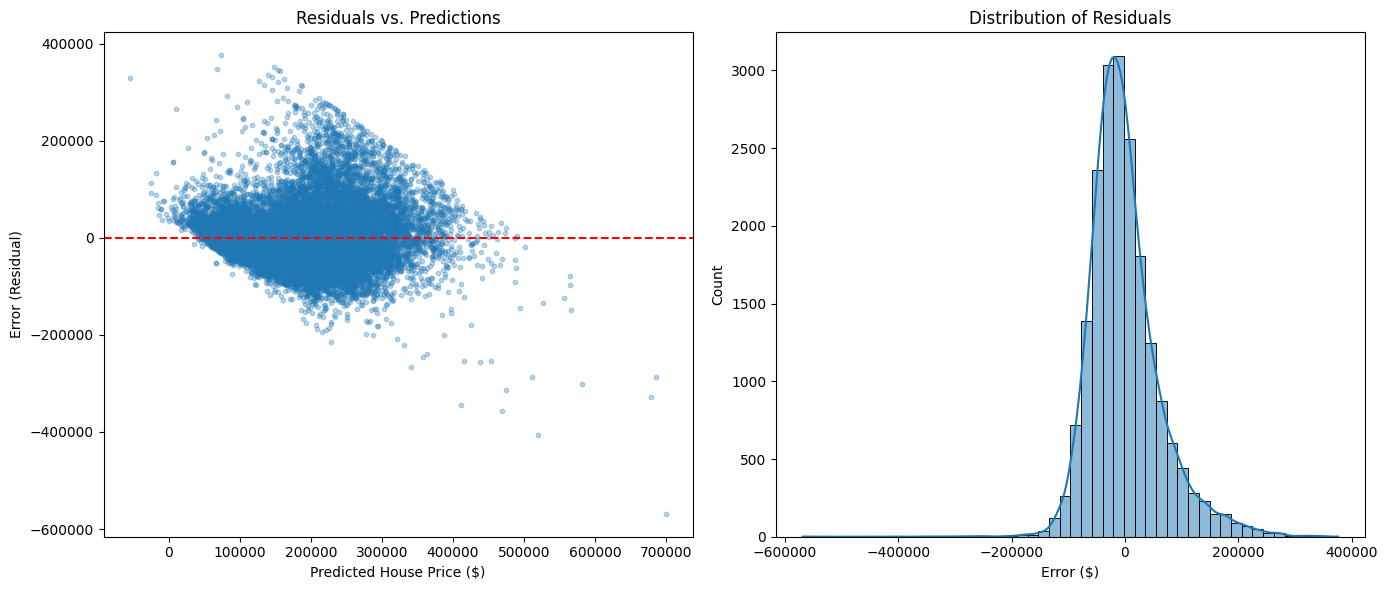

In [19]:
y_hat = model.predict(X)
residuals = y - y_hat

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_hat, residuals, alpha=0.3, s=10)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted House Price ($)")
plt.ylabel("Error (Residual)")
plt.title("Residuals vs. Predictions")

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, bins=50)
plt.xlabel("Error ($)")
plt.title("Distribution of Residuals")

plt.tight_layout()
plt.show()

Plotten 'Residuals vs. Predictions' visar att felen är relativt slumpmässigt fördelade kring noll, vilket indikerar att modellen fångar de linjära sambanden väl. Viss spridning vid högre priser tyder på att osäkerheten ökar för dyrare fastigheter. Histogrammet visar att residualerna följer en normalfördelning (en 'Bell Curve') centrerad runt noll, vilket styrker att modellens statistiska antaganden till stor del är uppfyllda.

In [23]:
intervals = model.confidence_intervals(alpha=0.4)
conf_df = pd.DataFrame({
    'Feature': ['Intercept'] + feature_names,
    'Lower Bound': intervals[:, 0],
    'Coefficient': model.b,
    'Upper Bound': intervals[:, 1]
})
display(conf_df)

# --- STEP 7: Feature Correlations ---
print("\n--- Pairwise Correlations (First 10) ---")
# Calculates Pearson r for ALL pairs of features
corrs = model.get_correlations(X)

# Display the strongest correlations (e.g., > 0.5)
strong_corrs = [c for c in corrs if abs(c[2]) > 0.5]
for i, j, r in strong_corrs:
    print(f"{X.columns[i]:<25} vs {X.columns[j]:<25}: {r:.4f}")

,Feature,Lower Bound,Coefficient,Upper Bound
0,Intercept,-2.163627e+06,-2.163627e+06,-2.163627e+06
1,longitude,-2.406829e+04,-2.406829e+04,-2.406829e+04
2,latitude,-2.146906e+04,-2.146906e+04,-2.146906e+04
3,housing_median_age,7.447362e+02,7.447362e+02,7.447362e+02
4,median_income,4.216065e+04,4.216065e+04,4.216065e+04
5,ocean_proximity_INLAND,-3.455910e+04,-3.455910e+04,-3.455910e+04
6,ocean_proximity_ISLAND,1.675123e+05,1.675123e+05,1.675123e+05
7,ocean_proximity_NEAR BAY,-1.341887e+03,2.432497e+02,1.828386e+03
8,ocean_proximity_NEAR OCEAN,9.091083e+03,9.091083e+03,9.091083e+03
9,rooms_per_household,2.397449e+03,2.397449e+03,2.397449e+03



--- Pairwise Correlations (First 10) ---
longitude                 vs latitude                 : -0.9241
median_income             vs bedrooms_per_room        : -0.6230
